In [1]:
import pandas as pd
import torch
import numpy as np
from gensim.models.word2vec import Word2Vec
from model import BatchProgramCC
from torch.autograd import Variable
import sys
from my_utilities import get_batch, eval_model_baseline
import argparse

/Users/konstantinos/Desktop/virtualenvs/astnn/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [13]:
train_on = "scb"

In [3]:
learning_rate  = 1e-3
lang           = "java"
HIDDEN_DIM     = 100
ENCODE_DIM     = 128
LABELS         = 1
EPOCHS         = 5
BATCH_SIZE     = 32
early_stopping = False
USE_GPU        = torch.cuda.is_available()

In [4]:
root = 'data/'

In [5]:
data_bcb_and_scb = pd.read_pickle(root+lang+'/scb/blocks.pickle').sample(frac=1)

In [6]:
word2vec = Word2Vec.load(root+lang+"/scb/embedding/node_w2v_128").wv
MAX_TOKENS = word2vec.vectors.shape[0]
EMBEDDING_DIM = word2vec.vectors.shape[1]
embeddings = np.zeros((MAX_TOKENS + 1, EMBEDDING_DIM), dtype="float32")
embeddings[:word2vec.vectors.shape[0]] = word2vec.vectors

In [9]:
data_bcb_and_scb.groupby('label').size()

label
0    19533
1    19523
dtype: int64

In [48]:
# Initialize model
model = BatchProgramCC(EMBEDDING_DIM,HIDDEN_DIM,MAX_TOKENS+1,ENCODE_DIM,LABELS,BATCH_SIZE,
                            USE_GPU, embeddings)
if USE_GPU:
    model.cuda()

parameters = model.parameters()
#optimizer = torch.optim.Adamax(parameters, lr=0.0001)
optimizer = torch.optim.Adam(parameters, lr=learning_rate)
loss_function = torch.nn.BCELoss()

In [55]:
if train_on == "bcb":
    data_train = data_bcb_and_scb[~data_bcb_and_scb['functionality_id'].isna()]
    
    data_test = data_bcb_and_scb[data_bcb_and_scb['functionality_id'].isna()]
else:
    data_train = data_bcb_and_scb[data_bcb_and_scb['functionality_id'].isna()]
    
    data_test = data_bcb_and_scb[~data_bcb_and_scb['functionality_id'].isna()]

In [15]:
len(data_train)

1994

In [16]:
len(data_test)

37062

In [17]:
prev_epoch_f1 = 0

In [39]:
data_test = data_test.sample(2000)

In [26]:
for epoch in range(5):
    loss_arr_train = []
    i = 0
    while i < len(data_train):
        model.train()
        batch = get_batch(data_train, i, BATCH_SIZE)
        train1_inputs, train2_inputs, train_labels = batch
        if USE_GPU:
            train1_inputs, train2_inputs, train_labels = train1_inputs, train2_inputs, train_labels.cuda()
    
        model.zero_grad()
        model.batch_size = len(train_labels)
        model.hidden = model.init_hidden()
    
        output = model(train1_inputs, train2_inputs)
    
        loss = loss_function(output, Variable(train_labels))
        loss.backward()
        optimizer.step()
        i += BATCH_SIZE
        print(loss.detach().cpu())

    
    f, similarity_scores = eval_model_baseline(model, data_test, BATCH_SIZE, USE_GPU)

    if f<prev_epoch_f1:
        print("Lower F1 than previous epoch. Early stopping...")
        sys.stdout.flush()
        break
    else:
        prev_epoch_f1 = f

tensor(0.7128)
tensor(0.6806)
tensor(0.6773)
tensor(0.6903)
tensor(0.6746)
tensor(0.6175)
tensor(0.6326)
tensor(0.7348)
tensor(0.6732)
tensor(0.6717)
tensor(0.6421)
tensor(0.6757)
tensor(0.6650)
tensor(0.6078)
tensor(0.6407)
tensor(0.7077)
tensor(0.6031)
tensor(0.6031)
tensor(0.5781)
tensor(0.5628)
tensor(0.5975)
tensor(0.7005)
tensor(0.6982)
tensor(0.5736)
tensor(0.5506)
tensor(0.6236)
tensor(0.6187)
tensor(0.5788)
tensor(0.6637)
tensor(0.6644)
tensor(0.7100)
tensor(0.6241)
tensor(0.5668)
tensor(0.5937)
tensor(0.5873)
tensor(0.5769)
tensor(0.6331)
tensor(0.5789)
tensor(0.5747)
tensor(0.5419)
tensor(0.5757)
tensor(0.5726)
tensor(0.6011)
tensor(0.5445)
tensor(0.5901)
tensor(0.5391)
tensor(0.5408)
tensor(0.5399)
tensor(0.6006)
tensor(0.5510)
tensor(0.5026)
tensor(0.5881)
tensor(0.5460)
tensor(0.5045)
tensor(0.5213)
tensor(0.5233)
tensor(0.5091)
tensor(0.5038)
tensor(0.5373)
tensor(0.4820)
tensor(0.5723)
tensor(0.5442)
tensor(0.4493)
F1=0.555, P=0.547, R=0.564, A=0.547 for similarity thre

/Users/konstantinos/Desktop/virtualenvs/astnn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/konstantinos/Desktop/virtualenvs/astnn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/konstantinos/Desktop/virtualenvs/astnn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kon

tensor(0.4816)
tensor(0.4952)
tensor(0.4713)
tensor(0.5274)
tensor(0.5198)
tensor(0.3675)
tensor(0.4202)
tensor(0.5107)
tensor(0.4624)
tensor(0.4288)
tensor(0.4621)
tensor(0.5134)
tensor(0.5177)
tensor(0.3696)
tensor(0.3691)
tensor(0.6084)
tensor(0.3786)
tensor(0.4117)
tensor(0.3887)
tensor(0.3172)
tensor(0.4151)
tensor(0.4939)
tensor(0.4692)
tensor(0.3787)
tensor(0.4246)
tensor(0.4629)
tensor(0.5072)
tensor(0.4270)
tensor(0.5359)
tensor(0.4823)
tensor(0.5223)
tensor(0.4210)
tensor(0.4062)
tensor(0.3804)
tensor(0.4256)
tensor(0.4295)
tensor(0.5034)
tensor(0.3639)
tensor(0.4129)
tensor(0.3920)
tensor(0.3652)
tensor(0.3846)
tensor(0.4905)
tensor(0.3784)
tensor(0.4797)
tensor(0.3423)
tensor(0.4426)
tensor(0.3200)
tensor(0.5237)
tensor(0.3801)
tensor(0.3464)
tensor(0.4382)
tensor(0.3771)
tensor(0.3771)
tensor(0.4224)
tensor(0.4452)
tensor(0.3677)
tensor(0.3577)
tensor(0.4262)
tensor(0.3686)
tensor(0.4385)
tensor(0.4136)
tensor(0.2908)


/Users/konstantinos/Desktop/Clone Generalization/astnn/clone/model.py:48: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if temp[j][0] is not -1:
/Users/konstantinos/Desktop/Clone Generalization/astnn/clone/model.py:48: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if temp[j][0] is not -1:
/Users/konstantinos/Desktop/Clone Generalization/astnn/clone/model.py:48: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if temp[j][0] is not -1:
/Users/konstantinos/Desktop/Clone Generalization/astnn/clone/model.py:48: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if temp[j][0] is not -1:
/Users/konstantinos/Desktop/Clone Generalization/astnn/clone/model.py:48: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if temp[j][0] is not -1:
/Users/konstantinos/Desktop/Clone Generalization/astnn/clone/model.py:48: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if temp[j][0] is not -1:


KeyboardInterrupt: 

In [40]:
f, similarity_scores = eval_model_baseline(model, data_test, BATCH_SIZE, USE_GPU)

F1=0.564, P=0.517, R=0.619, A=0.516 for similarity threshold 0.40
F1=0.672, P=0.505, R=1.000, A=0.506 for similarity threshold -0.50


In [28]:
import matplotlib.pyplot as plt

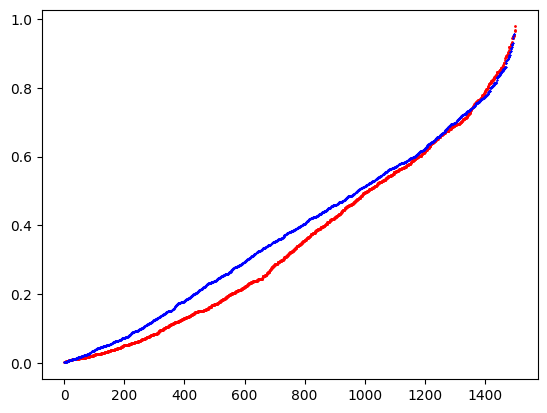

In [70]:
#test_labels = np.array(data_test['label'])
test_labels = np.array(test_data_t['label'])

similarity_scores = np.array(similarity_scores)
plt.plot(np.sort(similarity_scores[test_labels == 0].squeeze()), 'ro', markersize=1)
plt.plot(np.sort(similarity_scores[test_labels == 1].squeeze()), 'bx', markersize=1)


In [56]:
train_data_t = data_train
test_data_t  = data_test.sample(3000)

In [67]:
# Initialize model
model = BatchProgramCC(EMBEDDING_DIM,HIDDEN_DIM,MAX_TOKENS+1,ENCODE_DIM,LABELS,BATCH_SIZE,
                            USE_GPU, embeddings)
if USE_GPU:
    model.cuda()

parameters = model.parameters()
optimizer = torch.optim.Adamax(parameters)
#optimizer = torch.optim.Adam(parameters, lr=learning_rate)
loss_function = torch.nn.BCELoss()

In [69]:
# training procedure
prev_epoch_f1 = 0
for epoch in range(EPOCHS):
    print(epoch)
    sys.stdout.flush()

    start_time = time.time()
    # training epoch
    total_acc = 0.0
    total_loss = 0.0
    total = 0.0
    i = 0
    while i < len(train_data_t):
        batch = get_batch(train_data_t, i, BATCH_SIZE)
        i += BATCH_SIZE
        train1_inputs, train2_inputs, train_labels = batch
        if USE_GPU:
            train1_inputs, train2_inputs, train_labels = train1_inputs, train2_inputs, train_labels.cuda()

        model.zero_grad()
        model.batch_size = len(train_labels)
        model.hidden = model.init_hidden()
        output = model(train1_inputs, train2_inputs)

        loss = loss_function(output, Variable(train_labels))
        loss.backward()
        optimizer.step()
        print(loss.detach().cpu())

    ###### Start testing
    trues = []
    similarity_scores = []
    total_loss = 0.0
    total = 0.0
    i = 0
    while i < len(test_data_t):
        batch = get_batch(test_data_t, i, BATCH_SIZE)
        i += BATCH_SIZE
        test1_inputs, test2_inputs, test_labels = batch
        if USE_GPU:
            test_labels = test_labels.cuda()

        model.batch_size = len(test_labels)
        model.hidden = model.init_hidden()
        output = model(test1_inputs, test2_inputs)

        loss = loss_function(output, Variable(test_labels))

        # calc testing acc
        #predicted = (output.data > 0.5).cpu().numpy()
        similarity_scores.extend(output.data.cpu().numpy())
        trues.extend(test_labels.cpu().numpy())
        total += len(test_labels)
        total_loss += loss.item() * len(test_labels)


    trues = np.array(trues)
    max_F1 = -np.inf
    for similarity_threshold_int in range(0, 10):
        similarity_threshold = similarity_threshold_int/10
        # Classify code pairs based on the similarity score and threshold
        predicted_labels = (np.array(similarity_scores) > similarity_threshold)
        #acc = 1-np.sum(np.abs(predicted_labels-true_labels))/true_labels.shape[0]
        P, R, F1, _ = precision_recall_fscore_support(predicted_labels, trues, average='binary', pos_label=1)


        if F1 > max_F1:
            max_F1 = F1
            best_similarity_threshold = similarity_threshold

    predicted_labels = np.array(similarity_scores) > best_similarity_threshold
    p, r, f, _ = precision_recall_fscore_support(trues, predicted_labels, average='binary')
    acc = 1-np.sum(np.abs(predicted_labels-trues))/trues.shape[0]
    print("F1=%.3f, P=%.3f, R=%.3f, Acc=%0.3f for similarity threshold %0.2f" % (f, p, r, acc, best_similarity_threshold))

    predicted_labels = np.array(similarity_scores) > 0.5
    p, r, f, _ = precision_recall_fscore_support(trues, predicted_labels, average='binary')
    acc = 1-np.sum(np.abs(predicted_labels-trues))/trues.shape[0]
    print("F1=%.3f, P=%.3f, R=%.3f, Acc=%0.3f for similarity threshold 0.5" % (f, p, r, acc))

    sys.stdout.flush()

0
tensor(0.6744)
tensor(0.6722)
tensor(0.6643)
tensor(0.7078)
tensor(0.6804)
tensor(0.5954)
tensor(0.6225)
tensor(0.7328)
tensor(0.6623)
tensor(0.6615)
tensor(0.6360)
tensor(0.6898)
tensor(0.6638)
tensor(0.6026)
tensor(0.6322)
tensor(0.7104)
tensor(0.5848)
tensor(0.6066)
tensor(0.5701)
tensor(0.5464)
tensor(0.6095)
tensor(0.7019)
tensor(0.6844)
tensor(0.5794)
tensor(0.5491)
tensor(0.6119)
tensor(0.6356)
tensor(0.5861)
tensor(0.6664)
tensor(0.6438)
tensor(0.6930)
tensor(0.6194)
tensor(0.5861)
tensor(0.5966)
tensor(0.5809)
tensor(0.5700)
tensor(0.6265)
tensor(0.5716)
tensor(0.5587)
tensor(0.5438)
tensor(0.5684)
tensor(0.5445)
tensor(0.6110)
tensor(0.5305)
tensor(0.5831)
tensor(0.5549)
tensor(0.5389)
tensor(0.5169)
tensor(0.6049)
tensor(0.5263)
tensor(0.5040)
tensor(0.5931)
tensor(0.5600)
tensor(0.4743)
tensor(0.5226)
tensor(0.5191)
tensor(0.4939)
tensor(0.4898)
tensor(0.5436)
tensor(0.4645)
tensor(0.5592)
tensor(0.5372)
tensor(0.4619)
F1=0.666, P=0.499, R=1.000, Acc=0.499 for similarity 

/Users/konstantinos/Desktop/virtualenvs/astnn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/konstantinos/Desktop/virtualenvs/astnn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/konstantinos/Desktop/virtualenvs/astnn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


tensor(0.4815)
tensor(0.4905)
tensor(0.4718)
tensor(0.5285)
tensor(0.5130)
tensor(0.3697)
tensor(0.4837)
tensor(0.5263)
tensor(0.4732)
tensor(0.4585)
tensor(0.4506)
tensor(0.5636)
tensor(0.5319)
tensor(0.3807)
tensor(0.3750)
tensor(0.5929)
tensor(0.3852)
tensor(0.4177)
tensor(0.3904)
tensor(0.3422)
tensor(0.4318)
tensor(0.5102)
tensor(0.4813)
tensor(0.4252)
tensor(0.4121)
tensor(0.4672)
tensor(0.5165)
tensor(0.4694)
tensor(0.5358)
tensor(0.4475)
tensor(0.5413)
tensor(0.4225)
tensor(0.4500)
tensor(0.4080)
tensor(0.4233)
tensor(0.4182)
tensor(0.5399)
tensor(0.3837)
tensor(0.4111)
tensor(0.4089)
tensor(0.4091)
tensor(0.3910)
tensor(0.4764)
tensor(0.3933)
tensor(0.4631)
tensor(0.3951)
tensor(0.4629)
tensor(0.3445)
tensor(0.5152)
tensor(0.3763)
tensor(0.3429)
tensor(0.4755)
tensor(0.4208)
tensor(0.3550)
tensor(0.4511)
tensor(0.4390)
tensor(0.3916)
tensor(0.3776)
tensor(0.4192)
tensor(0.3564)
tensor(0.4359)
tensor(0.4194)
tensor(0.3165)
F1=0.666, P=0.499, R=1.000, Acc=0.499 for similarity th

/Users/konstantinos/Desktop/virtualenvs/astnn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


tensor(0.4326)
tensor(0.4240)
tensor(0.3792)
tensor(0.4062)
tensor(0.4256)
tensor(0.2741)
tensor(0.4155)
tensor(0.3768)
tensor(0.3552)
tensor(0.3613)
tensor(0.3638)
tensor(0.4663)
tensor(0.4445)
tensor(0.2772)
tensor(0.2622)
tensor(0.4924)
tensor(0.2975)
tensor(0.3294)
tensor(0.3100)
tensor(0.2588)
tensor(0.3347)
tensor(0.3705)
tensor(0.3834)
tensor(0.3792)
tensor(0.3584)
tensor(0.3773)
tensor(0.4406)
tensor(0.4057)
tensor(0.4366)
tensor(0.3378)
tensor(0.4558)
tensor(0.3110)
tensor(0.3709)
tensor(0.3169)
tensor(0.3358)
tensor(0.3408)
tensor(0.5148)
tensor(0.3005)
tensor(0.3332)
tensor(0.3187)
tensor(0.3268)
tensor(0.3208)
tensor(0.4122)
tensor(0.3325)
tensor(0.4074)
tensor(0.3200)
tensor(0.4151)
tensor(0.2684)
tensor(0.4366)
tensor(0.3166)
tensor(0.2719)
tensor(0.3869)
tensor(0.3287)
tensor(0.3104)
tensor(0.3853)
tensor(0.4168)
tensor(0.3524)
tensor(0.3256)
tensor(0.3377)
tensor(0.3144)
tensor(0.3508)
tensor(0.3624)
tensor(0.2331)
F1=0.666, P=0.499, R=1.000, Acc=0.499 for similarity th

In [52]:
import time
from sklearn.metrics import precision_recall_fscore_support

In [74]:
predicted_labels = np.array(similarity_scores) > 0.2
p, r, f, _ = precision_recall_fscore_support(trues, predicted_labels, average='binary')
acc = 1-np.sum(np.abs(predicted_labels-trues))/trues.shape[0]
print("F1=%.3f, P=%.3f, R=%.3f, Acc=%0.3f for similarity threshold 0.5" % (f, p, r, acc))

F1=0.607, P=0.530, R=0.711, Acc=0.541 for similarity threshold 0.5
